<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/NN_predict_v22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traininig NN Spectrum

# Loading Necesary Libraries

In [1]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os.path

from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import scipy.stats as st
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [2]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [3]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Bootstrapping

In [ ]:
#input_path = path + "/Spectrum/CNN/working_df.csv"

#working_df = pd.read_csv(input_path)
#working_df['Distance_km'] = working_df['Distance_km'].astype(int)

In [ ]:
distances = [x*80 for x in range(1, 26)]

## Get max and min values of each column

In [ ]:
def get_max_min_val_col(working_df):
  data_working_df = working_df.iloc[:, 6:working_df.shape[1]]
  h_list = list(data_working_df.columns.values)
  max_min_col_dict = {header:[] for header in h_list}

  for d in tqdm(distances):
    boot_dist_df = working_df.loc[working_df['Distance_km'] == d]
    for idx in range(6, boot_dist_df.shape[1]):
      max_val_col = float(boot_dist_df.iloc[:, [idx]].max()) # max val in col
      min_val_col = float(boot_dist_df.iloc[:, [idx]].min()) # min val in col
      h = boot_dist_df.iloc[:, [idx]].columns # header of col
      h = h[0]
      max_min_col_dict[h].append((d, min_val_col, max_val_col))
  return max_min_col_dict

## Create new samples using bootstrap technique

In [ ]:
def create_bootstrap_samples(working_df, max_min_col_dict, num_of_new_samples, previos_amt_of_samples=13):
  import random

  row_data = []
  PBRS_id_data = []
  Distance_km_data = []
  power_dBm_data = []
  span_data = []

  h_list = list(working_df.columns.values)
  new_data = {header:[] for header in h_list}


  last_row_in_old_df_val = working_df.shape[0]
  for new_sample in tqdm(range(num_of_new_samples)): # generating (num_of_new_samples) new samples for en data
    for d in distances:
      new_data['row'].append(last_row_in_old_df_val)
      last_row_in_old_df_val += 1
      new_data['PBRS_id'].append(new_sample+(previos_amt_of_samples+1))
      new_data['Channels'].append(1)

      new_data['Distance_km'].append(d)
      new_data['power_dBm'].append(0)
      new_data['#span'].append(int(d/80))

      for k, v in max_min_col_dict.items(): # header:(d, min_val_col, max_val_col)
        for val in v:
          if val[0] == d:
            bootstrap_val = round(random.uniform(val[1], val[2]), 14)
            new_data[str(k)].append(bootstrap_val)
            break
  new_data_df = pd.DataFrame.from_dict(new_data)

  return new_data_df

In [ ]:
#new_data_df = create_bootstrap_samples(working_df, max_min_col_dict, num_of_new_samples=87, previos_amt_of_samples=13)

## Combine previos df with bootstraped df

# Get working_df

## Aggregator

In [4]:
def prime_number_finder(stop_gap, total_num_of_data):
  prime_nums = []
  i=2
  while i <= stop_gap:
    if (total_num_of_data % i==0):
      prime_nums.append(i)
      break
    i+=1
  return prime_nums

In [5]:
def aggreagator_v2(df, stop_gap=50):
  total_num_of_data = df.shape[1]
  arr_prime = prime_number_finder(stop_gap, total_num_of_data)
  #agg_num = np.max(arr_prime)
  agg_num = arr_prime[0]

  # Creating new df of aggregate values
  agg_df = pd.DataFrame()

  mid_point = df.shape[1]/2

  agg=0
  loop_cnt=0
  init_column_cnt = 5
  while agg<=total_num_of_data:
    loop_cnt+=1
    # Obtain current last columns stop
    agg=agg_num+init_column_cnt
    # Select working columns
    new_df = df[df.columns[init_column_cnt:agg]]

    init_column_cnt += (agg_num)

    headers = list(new_df.columns.values) 
    if loop_cnt <= mid_point:
      # Get average of freq values for new header
      new_header_name  = headers[-1]
    else:
      new_header_name = headers[0]
    
    # Add aggragated values to new df
    agg_df[new_header_name] = new_df.mean(axis = 1)
  return agg_df

## Find cutoff index

In [6]:
def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

In [7]:
# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

In [8]:
def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  #agg_df = aggreagator_v2(df) disable aggragator causing odd data points

  col_vals = remove_tail_main(df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

In [9]:
def cut_off_idx(df): # return tuple with cut-off values (index_left_side, index_rigth_side)
  df_mean_sample = df.groupby(['PBRS_id']).mean()
  df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

  cut_points = {}
  print('Calculating the cutoff values:')
  for sample in tqdm(df_mean_sample.index):
    left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
    cut_points[sample] = (left_index_no, rigth_index_no)

  left_cut_off = np.min([v[0] for k, v in cut_points.items()])
  rigth_cut_off = np.max([v[1] for k, v in cut_points.items()])

  cut_point = (left_cut_off, rigth_cut_off)
  return cut_point

## Select working data

In [10]:
def select_working_data(df, cut_point): # implement cut_off values and Smoothing original df after cutt-of
  extra_info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, cut_point[0]+6:cut_point[1]+6]
  smoothed_data_frame = pd.DataFrame(savgol_filter(data_df, window_length = 5, polyorder = 2))
  
  # Adding back headers to the smoothed data
  rename_col = {}
  cnt = 0
  for col in data_df.columns:
    h_col = round(float(col), 5)
    rename_col[cnt] = h_col
    cnt += 1
  smoothed_data_frame.rename(columns=rename_col, inplace=True)

  working_df = pd.merge(extra_info_df, smoothed_data_frame, left_index=True, right_index=True)
  return working_df

In [11]:
def main_cutoff(input_path):
  print('Reading data from file.')
  df = pd.read_excel(input_path, sheet_name = "Sheet1", skiprows=1)
  df.iloc[0].fillna(method='bfill', inplace=True)
  df.iloc[1:df.shape[0]].fillna(method='pad', inplace=True)
  # Adding missing PBRS_id
  snippet = []
  val_cnt = 1
  idx = 0
  for sample in range(1, 101):
    for sample_id in range(0, 25):
      df.at[idx, 'PBRS_id'] = val_cnt
      idx +=1
      snippet.append(val_cnt)
    val_cnt += 1
  df['PBRS_id'] = df['PBRS_id'].astype(int)

  cut_point = cut_off_idx(df)
  working_df = select_working_data(df, cut_point)

  return working_df

## Run main cutoff

In [12]:
#input_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"
#orking_df = main_cutoff(input_path)
#display(working_df)

In [13]:
#working_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)

#New Train/Test Split

## Get Reference data

In [14]:
def get_reference_and_sample_data(working_df, num_reference, num_sample):
  reference_arr = [x for x in range(1, num_reference+1)]
  reference_data_df = working_df[working_df['PBRS_id'].isin(reference_arr)]

  sample_arr = [x for x in range(num_reference+1, num_sample+1)]
  sample_data_df = working_df[working_df['PBRS_id'].isin(sample_arr)]
  
  return reference_data_df, sample_data_df

## Get test/train split

In [15]:
def get_idx_train_test_split(working_df, trainingProp = 0.8):
  rows_training = np.array([])
  rows_testing = np.array([])
  distances = [x*80 for x in range(1, 26)]
  for d in distances:
    distance_working_df = working_df.loc[working_df['Distance_km'] == d]
    rows_mixed=np.random.permutation(distance_working_df.shape[0])

    training_amt = math.ceil(distance_working_df.shape[0]*trainingProp)
    testing_amt = distance_working_df.shape[0] - training_amt

    rows_training = np.append(rows_training, rows_mixed[:training_amt])
    rows_testing = np.append(rows_testing, rows_mixed[-testing_amt:])
  
  rows_training = rows_training.astype('int').tolist()
  rows_testing = rows_testing.astype('int').tolist()

  return rows_training, rows_testing

## Get frequencies filter

In [16]:
def frequencies_filter(df, num_selected_freq=20):
  info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, 6:df.shape[1]]
  span_val = int(data_df.shape[1]/num_selected_freq)
  for i in range(num_selected_freq):
    df2 = data_df.iloc[:, (i+1)*span_val].to_frame()
    if i+1 == 1:
      new_df = df2
    else:
      new_df = pd.merge(new_df, df2, left_index=True, right_index=True)
  new_df = info_df.join(new_df)
  
  return new_df

## Get features

In [87]:
#sample_freq_data_df
#distance_reference_df
#selected_rows = rows_training
def get_features(sample_freq_data_df, reference_freq_data_df, selected_rows):
  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []
  data_CI_lower = []
  data_CI_upper = []

  for row_idx in tqdm(selected_rows):
    data_Y = sample_freq_data_df.iloc[row_idx,3] # distance of row selected
    data_X = np.array(sample_freq_data_df.iloc[row_idx,6:sample_freq_data_df.shape[1]]) #array of data in row selected
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    data_ci = st.t.interval(alpha=0.90, df=len(data_X)-1, loc=np.mean(data_X), scale=st.sem(data_X))
    data_confidence_int_lower = data_ci[0]
    data_confidence_int_upper = data_ci[1]

    # Get reference data
    distance_reference_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == data_Y]

    pearson_vals = []
    confidence_vals_upper = []
    confidence_vals_lower = []
    for reference_row in range(0, reference_freq_data_df.shape[0]):
      reference_X = np.array(reference_freq_data_df.iloc[reference_row,6:reference_freq_data_df.shape[1]])
      pearson_vals.append(round(pearsonr(data_X, reference_X)[0], 5))

      reference_ci = st.t.interval(alpha=0.90, df=len(reference_X)-1, loc=np.mean(reference_X), scale=st.sem(reference_X))
      reference_confidence_int_lower = reference_ci[0]
      confidence_vals_lower.append(reference_confidence_int_lower)
      reference_confidence_int_upper = reference_ci[1]
      confidence_vals_upper.append(reference_confidence_int_upper)

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

    data_CI_lower.append(abs(np.min(confidence_vals_lower)-data_confidence_int_lower))
    data_CI_upper.append(abs(np.max(confidence_vals_upper)-data_confidence_int_upper))
  data = {'distance':data_distance,
                  'mean':data_mean,
                  'std':data_std,
                  'pearson_min':data_pearson_min,
                  'pearson_mean':data_pearson_mean,
                  'pearson_max':data_pearson_max,
                  'delta_CI_min':data_CI_lower,
                  'delta_CI_max':data_CI_upper}

  data_df = pd.DataFrame(data)

  return data_df

## Main train/test split

In [71]:
def get_train_test_split_main(input_path, num_of_freq_selected, reference_amt):
  working_df = pd.read_csv(input_path)
  working_df['Distance_km'] = working_df['Distance_km'].astype(int)

  reference_data_df, sample_data_df = get_reference_and_sample_data(working_df, num_reference=reference_amt, num_sample=100)

  reference_freq_data_df = frequencies_filter(reference_data_df, num_selected_freq=num_of_freq_selected)
  sample_freq_data_df = frequencies_filter(sample_data_df, num_selected_freq=num_of_freq_selected)

  rows_training, rows_testing = get_idx_train_test_split(sample_data_df, trainingProp = 0.8)
  print('Calculating train split:')
  training_df = get_features(sample_freq_data_df, reference_freq_data_df, rows_training)
  print('Calculating test split:')
  testing_df = get_features(sample_freq_data_df, reference_freq_data_df, rows_testing)

  return training_df, testing_df, sample_freq_data_df, reference_freq_data_df, rows_training, rows_testing

# Neural Network

In [ ]:
#training_df=pd.read_csv(path+'/Spectrum/NN/training_data_DNN.csv')

Y = training_df.iloc[:, 0].to_numpy().reshape(-1,1)
X = training_df.iloc[:, 1:training_df.shape[1]]

sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_train = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_train = sc_input.fit_transform(X) # convert features to values from 0 to 1

#testing_df=pd.read_csv(path+'/Spectrum/NN/testing_data_DNN.csv')

Y = testing_df.iloc[:, 0].to_numpy().reshape(-1,1) 
X = testing_df.iloc[:, 1:testing_df.shape[1]] #SELECT ONLY PEARSON OR STATS------------------------------------------------


sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_test = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_test = sc_input.fit_transform(X) # convert features to values from 0 to 1

## Training Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
    model = Sequential()
    model.add(Dense(76, input_dim = 7, activation = 'tanh'))
    model.add(Dense(38,activation='tanh'))
    model.add(Dense(19,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model

model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

start_time = time.time()
callback = [EarlyStopping(monitor='loss', patience=500)]#, TqdmCallback(verbose=2)]
model_ann.fit(X_train, Y_train, callbacks=callback)
time_train_ann = time.time() - start_time

In [ ]:
pickle.dump(model_ann,open(path+"/Spectrum/NN/NN_model.pkl","wb"))

if os.path.isfile(path+"/Spectrum/NN/NN_model.h5") is False:
  model_ann.model.save(path+"/Spectrum/NN/NN_model.h5")

INFO:tensorflow:Assets written to: ram://602ba244-a62d-46b4-90e4-35a00f331150/assets


INFO:tensorflow:Assets written to: ram://602ba244-a62d-46b4-90e4-35a00f331150/assets


In [ ]:
# Load network
from keras.models import load_model
mm = KerasRegressor(build_fn=ann, epochs=5000, batch_size=32, verbose=1)
mm.model = load_model(path+"/Spectrum/NN/NN_model.h5")

## Get predictions

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
    model = Sequential()
    model.add(Dense(76, input_dim = 7, activation = 'tanh'))
    model.add(Dense(38,activation='tanh'))
    model.add(Dense(19,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model

model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

start_time = time.time()
callback = [EarlyStopping(monitor='loss', patience=500)]#, TqdmCallback(verbose=2)]
model_ann.fit(X_train, Y_train, callbacks=callback)
time_train_ann = time.time() - start_time

,dist,pred,error
0,400,395.464417,0.011339
1,800,799.385010,0.000769
2,1200,1196.775879,0.002687
3,1520,1520.194580,0.000128
4,560,563.574036,0.006382
...,...,...,...
345,560,563.574036,0.006382
346,640,640.335999,0.000525
347,1440,1438.267456,0.001203
348,400,401.716766,0.004292


,dist,pred,error
0,400,395.464417,4.535583
1,800,799.385010,0.614990
2,1200,1196.775879,3.224121
3,1520,1520.194580,0.194580
4,560,563.574036,3.574036
...,...,...,...
345,560,563.574036,3.574036
346,640,640.335999,0.335999
347,1440,1438.267456,1.732544
348,400,401.716766,1.716766


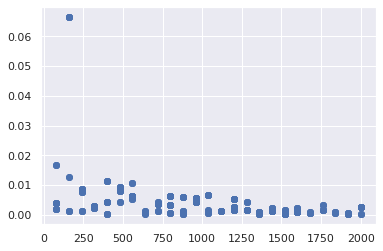

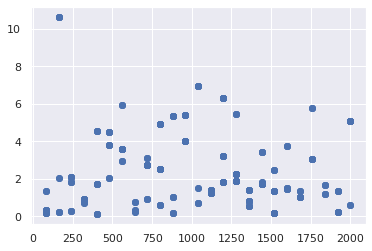

In [ ]:
# Predit
start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
pred=list(Y_test_pred)

time_eval_ann=time.time()-start_time

dist_min=sc_output.data_min_[0] # 80
dist_max=sc_output.data_max_[0] # 2000

real=list(list(zip(*Y_test))[0])
real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
real_abs=[int(np.round(i)) for i in real_abs]
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))
res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
display(res)
res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
display(res_v2)
#res.to_csv(path+"/Spectrum/NN/results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()
plt.plot(real_abs,error_v2,'bo')
plt.show()

# Main

In [ ]:
def main(input_path, num_of_freq_selected, reference_amt):

  training_df, testing_df = get_train_test_split_main(input_path, num_of_freq_selected, reference_amt)

  training_df.to_csv(path+"/Spectrum/NN/train_test_splits/training_data_NN_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)
  testing_df.to_csv(path+"/Spectrum/NN/train_test_splits/testing_data_NN_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)

  Y = training_df.iloc[:, 0].to_numpy().reshape(-1,1)
  X = training_df.iloc[:, 1:training_df.shape[1]]

  sc_input = MinMaxScaler()
  sc_output = MinMaxScaler()
  Y_train = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
  X_train = sc_input.fit_transform(X) # convert features to values from 0 to 1

  Y = testing_df.iloc[:, 0].to_numpy().reshape(-1,1)
  X = testing_df.iloc[:, 1:testing_df.shape[1]]


  sc_input = MinMaxScaler()
  sc_output = MinMaxScaler()
  Y_test = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
  X_test = sc_input.fit_transform(X) # convert features to values from 0 to 1

  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  def ann():
      model = Sequential()
      model.add(Dense(76, input_dim = 7, activation = 'tanh'))
      model.add(Dense(38,activation='tanh'))
      model.add(Dense(19,activation='tanh'))
      model.add(Dense(1))
      model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
      return model

  model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

  start_time = time.time()
  callback = [EarlyStopping(monitor='loss', patience=500)]#, TqdmCallback(verbose=2)]
  model_ann.fit(X_train, Y_train, callbacks=callback)
  time_train_ann = time.time() - start_time

  # Save model
  #pickle.dump(model_ann,open(path+"/Spectrum/NN/NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))

  if os.path.isfile(path+"/Spectrum/NN/NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5") is False:
    model_ann.model.save(path+"/Spectrum/NN/NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")

  # Load network
  #from keras.models import load_model
  #mm = KerasRegressor(build_fn=ann, epochs=5000, batch_size=32, verbose=1)
  #mm.model = load_model(path+"/Spectrum/NN/NNs/NN_model.h5")

  print('Results (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')')
  # Predit
  start_time = time.time()
  Y_test_pred=model_ann.predict(X_test)
  pred=list(Y_test_pred)

  time_eval_ann=time.time()-start_time

  dist_min=sc_output.data_min_[0] # 80
  dist_max=sc_output.data_max_[0] # 2000

  real=list(list(zip(*Y_test))[0])
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
  res.to_csv(path+"/Spectrum/NN/NN_results_error/results_curve_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)

  res_v2=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error_v2})
  res.to_csv(path+"/Spectrum/NN/NN_results_error/results_deltas_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)
  
  plt.plot(real_abs,error,'bo')
  plt.xlabel('Distances') 
  plt.ylabel('Error') 
  plt.title("Results Curve (freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+")")
  plt.savefig(path+"/Spectrum/NN/NN_results_plots/results_curve_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".png")
  plt.show()
  
  plt.plot(real_abs,error_v2,'bo')
  plt.xlabel('Distances') 
  plt.ylabel('Error') 
  plt.title("Results Deltas (freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+")")
  plt.savefig(path+"/Spectrum/NN/NN_results_plots/results_deltas_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".png")
  plt.show()

  print('----------------------------------------------------------------------')

# TEST Freq and Reference size

Calculating train split:


100%|██████████| 1000/1000 [01:12<00:00, 13.88it/s]


Calculating test split:


100%|██████████| 250/250 [00:18<00:00, 13.67it/s]


Training model (freq_20_reference_50)...
Results (freq_20_reference_50)


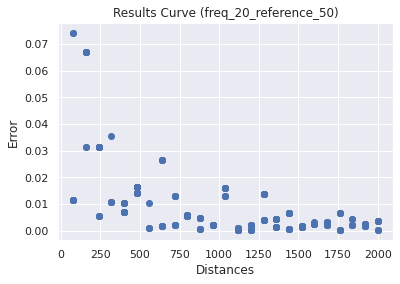

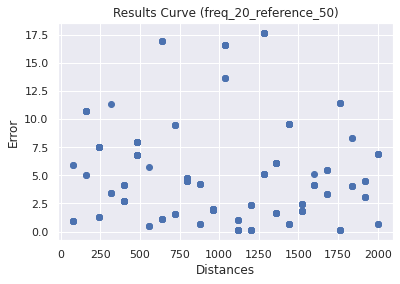

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1000/1000 [01:12<00:00, 13.71it/s]


Calculating test split:


100%|██████████| 250/250 [00:17<00:00, 13.99it/s]


Training model (freq_15_reference_50)...
Results (freq_15_reference_50)


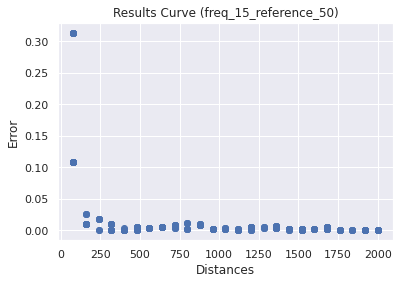

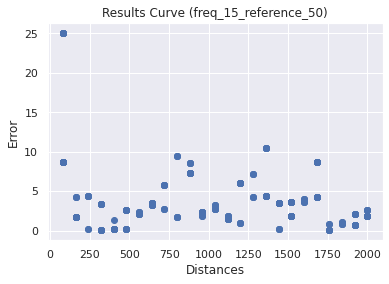

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1000/1000 [01:12<00:00, 13.81it/s]


Calculating test split:


100%|██████████| 250/250 [00:18<00:00, 13.48it/s]


Training model (freq_10_reference_50)...
Results (freq_10_reference_50)


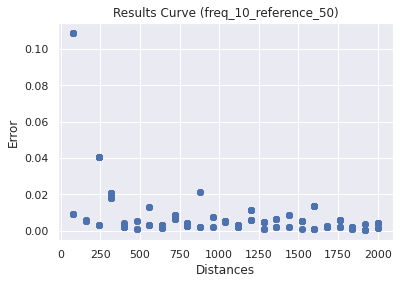

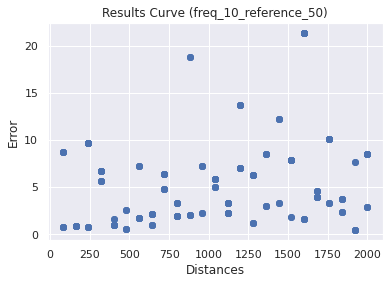

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1000/1000 [01:12<00:00, 13.84it/s]


Calculating test split:


100%|██████████| 250/250 [00:18<00:00, 13.58it/s]


Training model (freq_7_reference_50)...
Results (freq_7_reference_50)


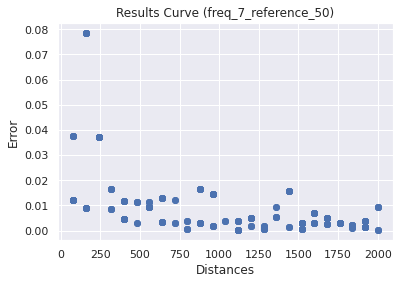

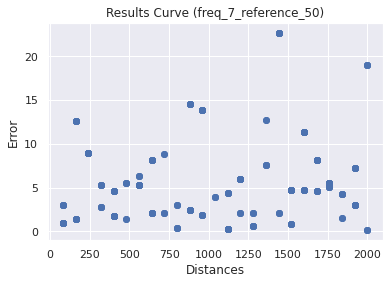

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1000/1000 [01:11<00:00, 13.93it/s]


Calculating test split:


100%|██████████| 250/250 [00:17<00:00, 13.89it/s]


Training model (freq_5_reference_50)...
Results (freq_5_reference_50)


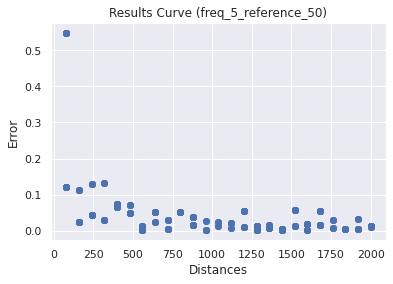

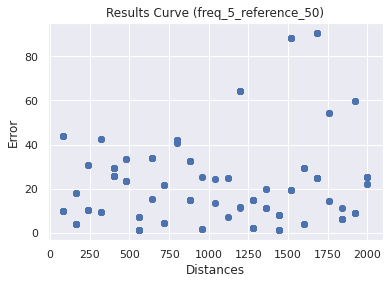

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1400/1400 [01:03<00:00, 22.05it/s]


Calculating test split:


100%|██████████| 350/350 [00:16<00:00, 21.80it/s]


Training model (freq_20_reference_30)...
Results (freq_20_reference_30)


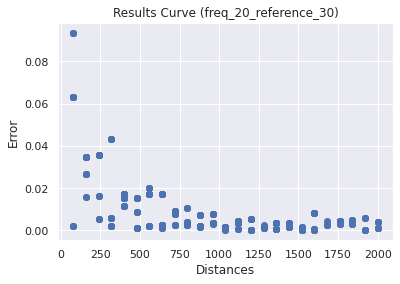

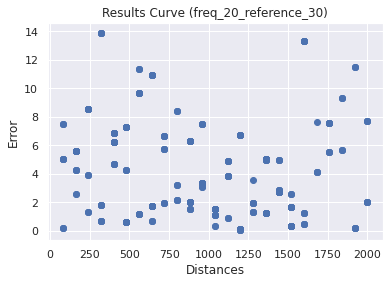

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1400/1400 [01:03<00:00, 22.09it/s]


Calculating test split:


100%|██████████| 350/350 [00:15<00:00, 22.03it/s]


Training model (freq_15_reference_30)...
Results (freq_15_reference_30)


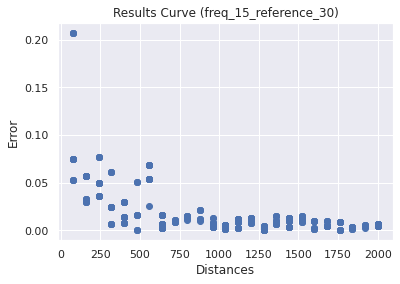

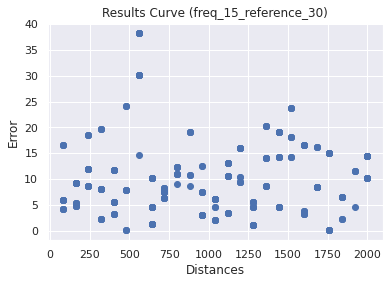

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1400/1400 [01:02<00:00, 22.46it/s]


Calculating test split:


100%|██████████| 350/350 [00:15<00:00, 22.86it/s]


Training model (freq_10_reference_30)...
Results (freq_10_reference_30)


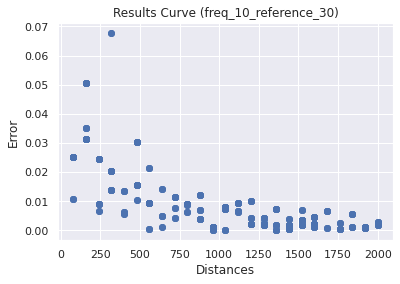

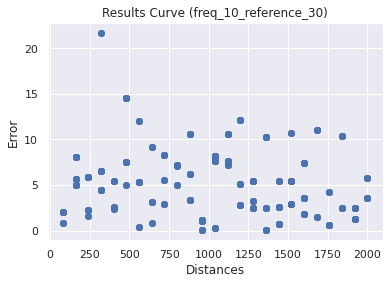

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1400/1400 [01:01<00:00, 22.90it/s]


Calculating test split:


100%|██████████| 350/350 [00:15<00:00, 22.35it/s]


Training model (freq_7_reference_30)...
Results (freq_7_reference_30)


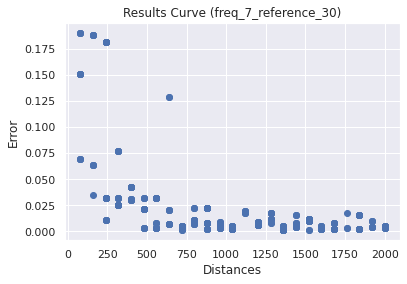

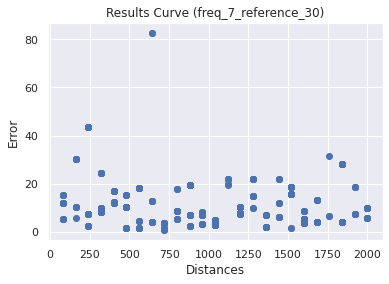

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1400/1400 [01:03<00:00, 22.17it/s]


Calculating test split:


100%|██████████| 350/350 [00:15<00:00, 22.66it/s]


Training model (freq_5_reference_30)...
Results (freq_5_reference_30)


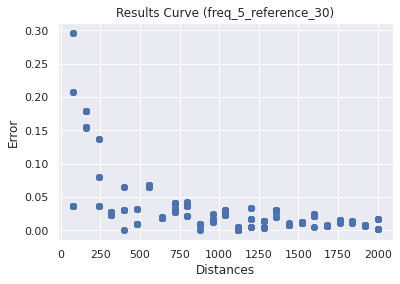

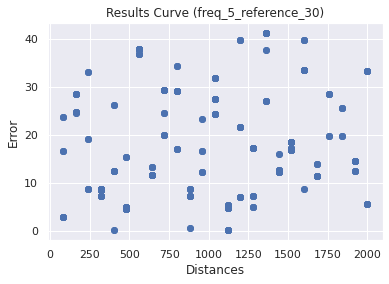

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1600/1600 [00:48<00:00, 33.27it/s]


Calculating test split:


100%|██████████| 400/400 [00:12<00:00, 32.91it/s]


Training model (freq_20_reference_20)...
Results (freq_20_reference_20)


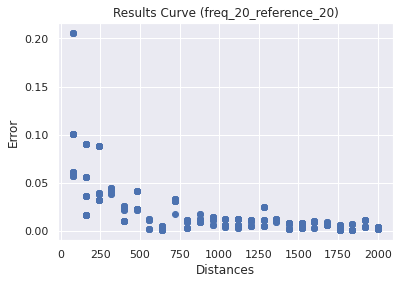

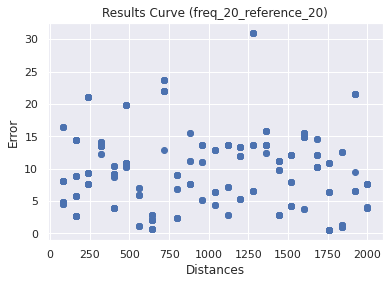

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1600/1600 [00:50<00:00, 31.63it/s]


Calculating test split:


100%|██████████| 400/400 [00:12<00:00, 32.44it/s]


Training model (freq_15_reference_20)...
Results (freq_15_reference_20)


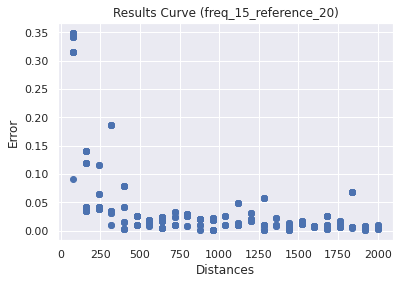

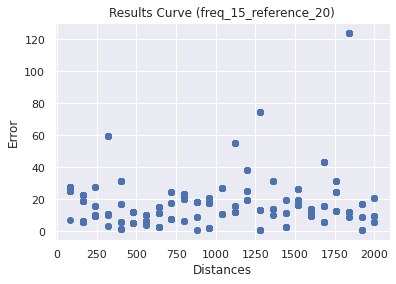

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1600/1600 [00:48<00:00, 32.74it/s]


Calculating test split:


100%|██████████| 400/400 [00:12<00:00, 32.57it/s]


Training model (freq_10_reference_20)...
Results (freq_10_reference_20)


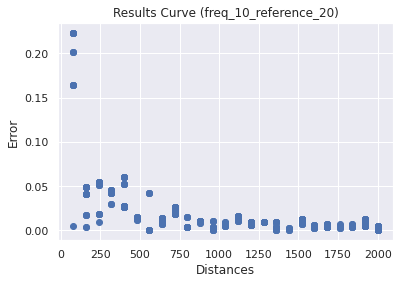

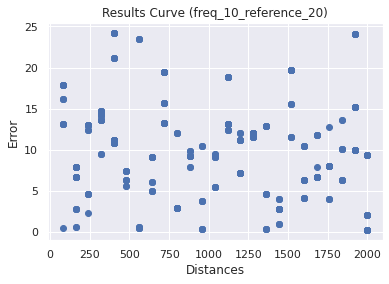

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1600/1600 [00:47<00:00, 33.39it/s]


Calculating test split:


100%|██████████| 400/400 [00:11<00:00, 34.08it/s]


Training model (freq_7_reference_20)...
Results (freq_7_reference_20)


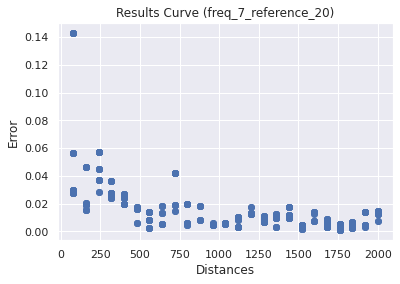

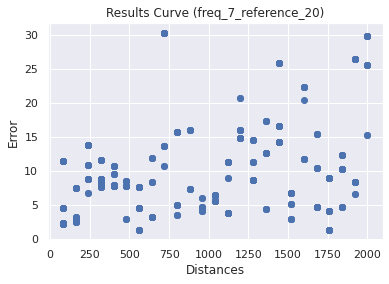

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1600/1600 [00:47<00:00, 33.56it/s]


Calculating test split:


100%|██████████| 400/400 [00:12<00:00, 32.68it/s]


Training model (freq_5_reference_20)...
Results (freq_5_reference_20)


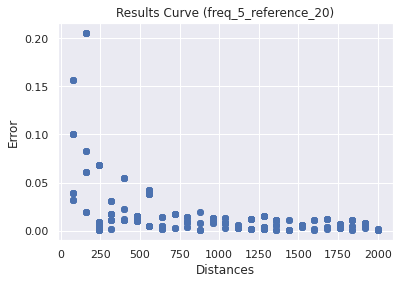

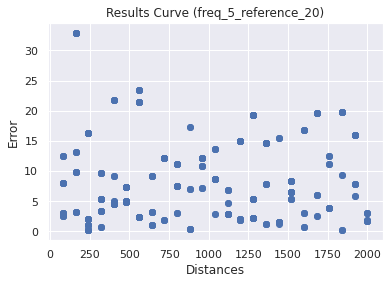

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1800/1800 [00:29<00:00, 61.77it/s]


Calculating test split:


100%|██████████| 450/450 [00:07<00:00, 62.53it/s]


Training model (freq_20_reference_10)...
Results (freq_20_reference_10)


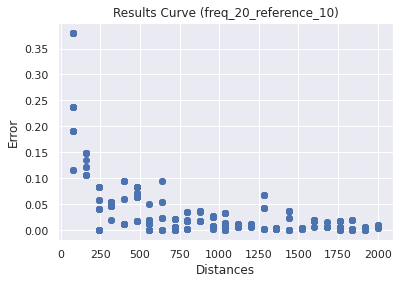

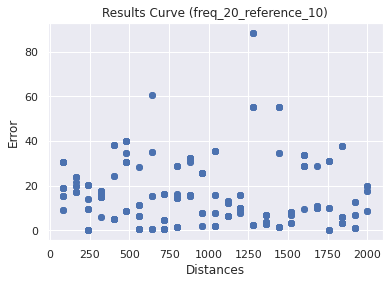

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1800/1800 [00:31<00:00, 58.05it/s]


Calculating test split:


100%|██████████| 450/450 [00:07<00:00, 61.81it/s]


Training model (freq_15_reference_10)...
Results (freq_15_reference_10)


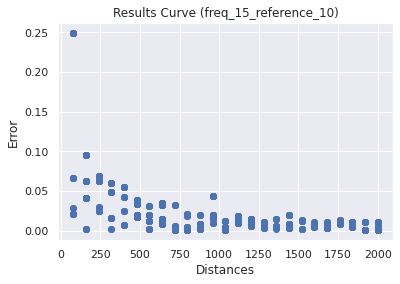

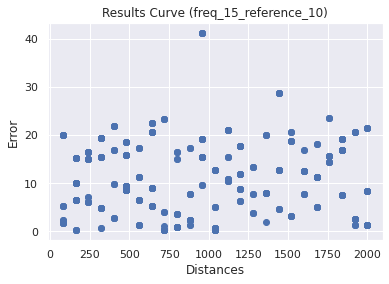

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1800/1800 [00:29<00:00, 61.50it/s]


Calculating test split:


100%|██████████| 450/450 [00:07<00:00, 59.48it/s]


Training model (freq_10_reference_10)...
Results (freq_10_reference_10)


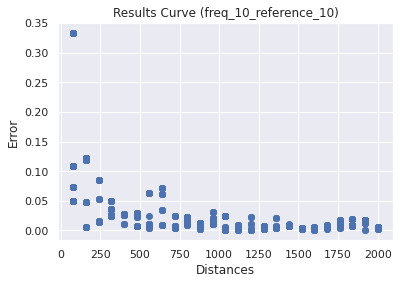

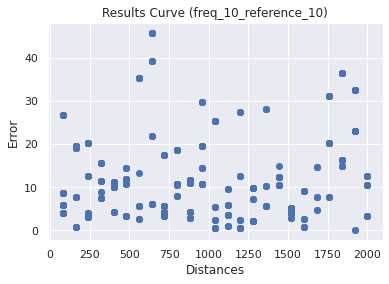

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1800/1800 [00:30<00:00, 59.67it/s]


Calculating test split:


100%|██████████| 450/450 [00:07<00:00, 59.32it/s]


Training model (freq_7_reference_10)...
Results (freq_7_reference_10)


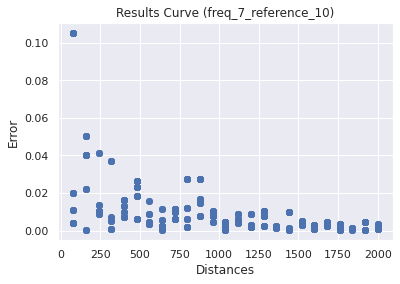

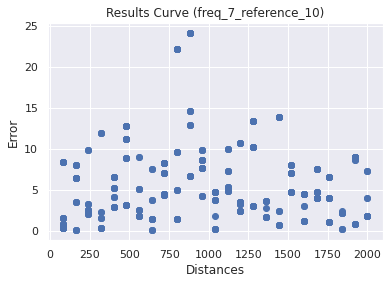

----------------------------------------------------------------------
Calculating train split:


100%|██████████| 1800/1800 [00:29<00:00, 60.96it/s]


Calculating test split:


100%|██████████| 450/450 [00:07<00:00, 61.25it/s]


Training model (freq_5_reference_10)...
Results (freq_5_reference_10)


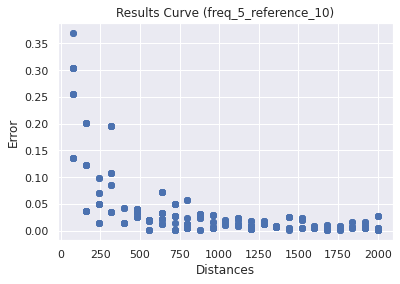

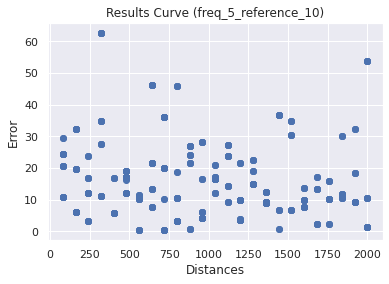

----------------------------------------------------------------------


In [ ]:
#num_of_freq_selected = 20
#reference_amt = 30
input_path = path + "/Spectrum/NN/new_working_df.csv"

tests = {50:[20, 15, 10, 7, 5],
         30:[20, 15, 10, 7, 5],
         20:[20, 15, 10, 7, 5],
         10:[20, 15, 10, 7, 5]}

for k, v in tests.items():
  for val in v:
    num_of_freq_selected = val
    reference_amt = k
    main(input_path, num_of_freq_selected, reference_amt)

#Test new data

In [73]:
def get_label_data_splits(input_path, num_of_freq_selected, reference_amt):

  training_df, testing_df, sample_freq_data_df, reference_freq_data_df, rows_training, rows_testing = get_train_test_split_main(input_path, num_of_freq_selected, reference_amt)

  training_df.to_csv(path+"/Spectrum/NN/train_test_splits/new_data_training_data_NN_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)
  testing_df.to_csv(path+"/Spectrum/NN/train_test_splits/new_data_testing_data_NN_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)

  Y = training_df.iloc[:, 0].to_numpy().reshape(-1,1)
  X = training_df.iloc[:, 1:training_df.shape[1]]

  sc_input = MinMaxScaler()
  sc_output = MinMaxScaler()
  Y_train = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
  X_train = sc_input.fit_transform(X) # convert features to values from 0 to 1

  Y = testing_df.iloc[:, 0].to_numpy().reshape(-1,1)
  X = testing_df.iloc[:, 1:testing_df.shape[1]]

  Y_test = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
  X_test = sc_input.fit_transform(X) # convert features to values from 0 to 1

  return Y_train, X_train, Y_test, X_test, sc_output, training_df, testing_df, sample_freq_data_df, reference_freq_data_df, rows_training, rows_testing

In [61]:
def train_model(X_train, Y_train):
  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  def ann():
      model = Sequential()
      model.add(Dense(76, input_dim = 7, activation = 'tanh'))
      model.add(Dense(38,activation='tanh'))
      model.add(Dense(19,activation='tanh'))
      model.add(Dense(1))
      model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
      return model

  model_ann = KerasRegressor(build_fn=ann,epochs=8000,batch_size=32, verbose=0)

  start_time = time.time()
  callback = [EarlyStopping(monitor='loss', patience=500)]#, TqdmCallback(verbose=2)]
  model_ann.fit(X_train, Y_train, callbacks=callback)
  time_train_ann = time.time() - start_time

  # Save model
  #pickle.dump(model_ann,open(path+"/Spectrum/NN/NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))

  model_ann.model.save(path+"/Spectrum/NN/NNs/final_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")
  
  return model_ann

In [57]:
def predict_test(model_ann, Y_test, X_test, sc_output, testing_df, reference_freq_data_df, remove_outliers=0.05, reference_evaluation=False, reference_eval_params=(30, [80, 1040, 2000], [80, 160, 240, 320, 400, 480, 560, 640, 720, 800, 880, 960, 1040, 1120, 1200, 1280, 1360, 1440, 1520, 1600, 1680, 1760, 1840, 1920, 2000])):
  print('Results (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')')
  # Predit
  start_time = time.time()
  Y_test_pred=model_ann.predict(X_test)
  pred=list(Y_test_pred)

  time_eval_ann=time.time()-start_time

  dist_min=sc_output.data_min_[0] # 80
  dist_max=sc_output.data_max_[0] # 2000

  real=list(list(zip(*Y_test))[0])
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar
  real_abs_e1 = real_abs
  real_abs_e2 = real_abs

  pred_abs_e1 = pred_abs
  pred_abs_e2 = pred_abs

  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  remove_outliers = math.ceil((len(error_v2)*remove_outliers)/2)

  for outlier in range(1, remove_outliers+1):
    min_idx_e1 = np.argmin(error)
    max_idx_e1 = np.argmax(error)

    min_idx_e2 = np.argmin(error_v2)
    max_idx_e2 = np.argmax(error_v2)

    error = np.delete(error, min_idx_e1)
    error = np.delete(error, max_idx_e1)
    real_abs_e1 = np.delete(real_abs_e1, min_idx_e1)
    real_abs_e1 = np.delete(real_abs_e1, max_idx_e1)
    pred_abs_e1 = np.delete(pred_abs_e1, min_idx_e1)
    pred_abs_e1 = np.delete(pred_abs_e1, max_idx_e1)

    error_v2 = np.delete(error_v2, min_idx_e2)
    error_v2 = np.delete(error_v2, max_idx_e2)
    real_abs_e2 = np.delete(real_abs_e2, min_idx_e1)
    real_abs_e2 = np.delete(real_abs_e2, max_idx_e1)
    pred_abs_e2 = np.delete(pred_abs_e2, min_idx_e1)
    pred_abs_e2 = np.delete(pred_abs_e2, max_idx_e1)

  res=pd.DataFrame({"dist":real_abs_e1,"pred":pred_abs_e1,"error":error})
  res.to_csv(path+"/Spectrum/NN/NN_results_error/new_data_results_curve_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)

  res_v2=pd.DataFrame({"dist":real_abs_e2,"pred":pred_abs_e2,"error":error_v2})
  res.to_csv(path+"/Spectrum/NN/NN_results_error/new_data_results_deltas_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)
  
  plt.plot(real_abs_e1,error,'bo')
  plt.xlabel('Distances') 
  plt.ylabel('Error') 
  plt.title("Results Curve (freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+")")
  plt.savefig(path+"/Spectrum/NN/NN_results_plots/new_data_results_curve_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".png")
  plt.show()
  
  plt.plot(real_abs_e2,error_v2,'bo')
  plt.xlabel('Distances') 
  plt.ylabel('Error') 
  plt.title("Results Deltas (freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+")")
  plt.savefig(path+"/Spectrum/NN/NN_results_plots/new_data_results_deltas_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".png")
  plt.show()

In [52]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 7, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
  return model

In [88]:
num_of_freq_selected = 10
reference_amt = 30
input_path = path + "/Spectrum/NN/new_data_working_df.csv"

Y_train_c, X_train_c, Y_test_c, X_test_c, sc_output_c, training_df, testing_df, sample_freq_data_df, reference_freq_data_df, rows_training, rows_testing = get_label_data_splits(input_path, num_of_freq_selected, reference_amt)

Calculating train split:


100%|██████████| 1400/1400 [16:37<00:00,  1.40it/s]


Calculating test split:


100%|██████████| 350/350 [04:01<00:00,  1.45it/s]


In [89]:
saved_references = reference_freq_data_df
saved_sample_freq_data_df = sample_freq_data_df

In [90]:
saved_references

,row,PBRS_id,Channels,Distance_km,power_dBm,#span,-32.4375,-24.96875,-17.5,-10.03125,-2.5625,4.90625,12.375,19.84375,27.3125,34.78125
0,1,1,1,80,0,1,-12.613267,-10.303986,-13.136877,-16.928177,-13.943262,-11.839301,-13.141004,-11.781068,-14.321212,-54.361885
1,2,1,1,160,0,2,-12.651791,-10.366297,-13.277690,-16.792335,-13.848330,-11.826453,-13.202544,-11.856454,-14.437985,-48.281322
2,3,1,1,240,0,3,-12.721171,-10.003051,-13.275724,-16.735231,-13.783038,-11.758913,-13.125277,-11.894570,-14.452363,-49.403539
3,4,1,1,320,0,4,-12.700428,-10.085274,-13.289329,-16.889779,-14.052985,-11.637977,-13.291929,-11.829818,-14.585948,-49.245449
4,5,1,1,400,0,5,-12.818864,-9.915748,-13.232025,-16.803108,-13.878809,-11.654389,-13.518675,-11.860261,-14.476836,-44.886542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,746,30,1,1680,0,21,-7.813473,-10.407275,-7.925787,-9.388081,-11.561470,-14.561911,-8.634992,-13.390757,-18.055485,-35.337212
746,747,30,1,1760,0,22,-7.779251,-10.563270,-7.936738,-9.613096,-11.567978,-15.052498,-8.888634,-13.403554,-18.244065,-34.578326
747,748,30,1,1840,0,23,-7.758593,-10.478629,-7.887434,-9.414192,-11.524794,-15.159448,-8.945708,-13.429386,-18.240945,-34.710843
748,749,30,1,1920,0,24,-7.621827,-10.508957,-7.890660,-9.455494,-11.421303,-14.932622,-9.083455,-13.437311,-18.402125,-33.401499


In [91]:
saved_sample_freq_data_df

,row,PBRS_id,Channels,Distance_km,power_dBm,#span,-32.4375,-24.96875,-17.5,-10.03125,-2.5625,4.90625,12.375,19.84375,27.3125,34.78125
750,751,31,1,80,0,1,-9.188371,-13.835969,-15.344643,-13.615598,-9.417588,-6.801097,-6.538896,-10.000159,-9.832129,-60.263485
751,752,31,1,160,0,2,-9.378143,-14.034919,-15.483584,-13.560789,-9.532963,-6.675520,-6.557558,-10.028081,-9.960206,-49.149298
752,753,31,1,240,0,3,-9.450185,-13.927223,-15.420175,-13.476049,-9.512494,-6.781303,-6.538667,-10.054840,-9.994697,-52.120363
753,754,31,1,320,0,4,-9.507144,-14.295526,-15.564391,-13.417304,-9.600322,-6.676071,-6.474087,-10.183276,-10.133165,-43.896890
754,755,31,1,400,0,5,-9.549214,-14.034864,-15.458071,-13.457040,-9.562147,-6.394234,-6.554161,-10.013257,-10.218594,-38.266136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2496,100,1,1680,0,21,-8.325286,-5.352142,-19.596932,-14.500246,-7.772893,-12.803440,-12.871296,-10.953146,-10.941237,-33.048413
2496,2497,100,1,1760,0,22,-8.225016,-5.304132,-19.853940,-14.508272,-7.758869,-12.741685,-12.985982,-10.722518,-10.948950,-31.975633
2497,2498,100,1,1840,0,23,-8.141141,-5.249944,-19.687314,-14.526115,-7.827789,-12.765855,-13.171294,-10.734475,-10.939325,-31.989874
2498,2499,100,1,1920,0,24,-8.237431,-5.247242,-19.764340,-14.864670,-7.838319,-12.698725,-13.061918,-10.860332,-11.010659,-33.667279


In [92]:
model_ann_c = train_model(X_train_c, Y_train_c)

Training model (freq_10_reference_30)...


Results (freq_10_reference_30)


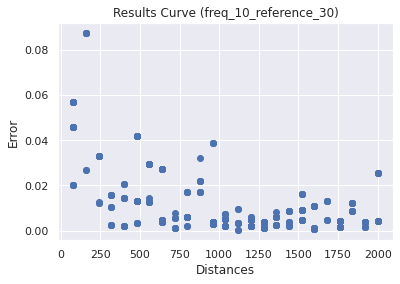

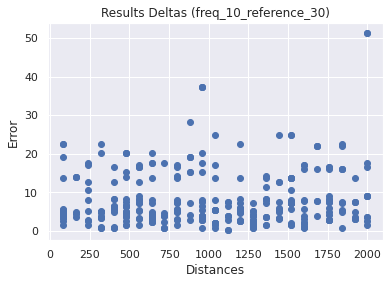

In [93]:
#predict_test(model_ann_c, Y_test_c, X_test_c, sc_output_c)
predict_test(model_ann_c, Y_test_c, X_test_c, sc_output_c, testing_df, reference_freq_data_df, remove_outliers=0.05, reference_evaluation=True)

### Hope

In [81]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 7, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
  return model

# Load network
from keras.models import load_model
mm = KerasRegressor(build_fn=ann, epochs=5000, batch_size=32, verbose=0)
mm.model = load_model(path+"/Spectrum/NN/NNs/final_new_data_NN_model_freq_10_reference_30.h5")

In [98]:
#sample_freq_data_df
#distance_reference_df
#selected_rows = rows_training
def get_features_v2(sample_freq_data_df, reference_freq_data_df, selected_rows):
  data_distance = []
  data_mean = []
  data_std = []
  data_pearson_min = []
  data_pearson_mean = []
  data_pearson_max = []
  data_CI_lower = []
  data_CI_upper = []

  for row_idx in tqdm(selected_rows):
    data_Y = sample_freq_data_df.iloc[row_idx,3] # distance of row selected
    data_X = np.array(sample_freq_data_df.iloc[row_idx,6:sample_freq_data_df.shape[1]]) #array of data in row selected
    data_distance.append(data_Y)
    data_std.append(np.std(data_X))
    data_mean.append(np.mean(data_X))

    data_ci = st.t.interval(alpha=0.90, df=len(data_X)-1, loc=np.mean(data_X), scale=st.sem(data_X))
    data_confidence_int_lower = data_ci[0]
    data_confidence_int_upper = data_ci[1]

    # Get reference data
    
    distance_reference_df = reference_freq_data_df.loc[reference_freq_data_df['Distance_km'] == data_Y]
    if distance_reference_df.shape[0] != 0:
      mod_df = distance_reference_df
    else:
      mod_df = reference_freq_data_df

    pearson_vals = []
    confidence_vals_upper = []
    confidence_vals_lower = []
    for reference_row in range(0, mod_df.shape[0]):
      reference_X = np.array(mod_df.iloc[reference_row,6:mod_df.shape[1]])
      pearson_vals.append(round(pearsonr(data_X, reference_X)[0], 5))

      reference_ci = st.t.interval(alpha=0.90, df=len(reference_X)-1, loc=np.mean(reference_X), scale=st.sem(reference_X))
      reference_confidence_int_lower = reference_ci[0]
      confidence_vals_lower.append(reference_confidence_int_lower)
      reference_confidence_int_upper = reference_ci[1]
      confidence_vals_upper.append(reference_confidence_int_upper)

    data_pearson_min.append(np.min(pearson_vals))
    data_pearson_mean.append(np.mean(pearson_vals))    
    data_pearson_max.append(np.max(pearson_vals))

    data_CI_lower.append(abs(np.min(confidence_vals_lower)-data_confidence_int_lower))
    data_CI_upper.append(abs(np.max(confidence_vals_upper)-data_confidence_int_upper))
  data = {'distance':data_distance,
                  'mean':data_mean,
                  'std':data_std,
                  'pearson_min':data_pearson_min,
                  'pearson_mean':data_pearson_mean,
                  'pearson_max':data_pearson_max,
                  'delta_CI_min':data_CI_lower,
                  'delta_CI_max':data_CI_upper}

  data_df = pd.DataFrame(data)

  return data_df

100%|██████████| 350/350 [00:12<00:00, 28.76it/s]


-----------------------------------------------------------------------
Resuslts


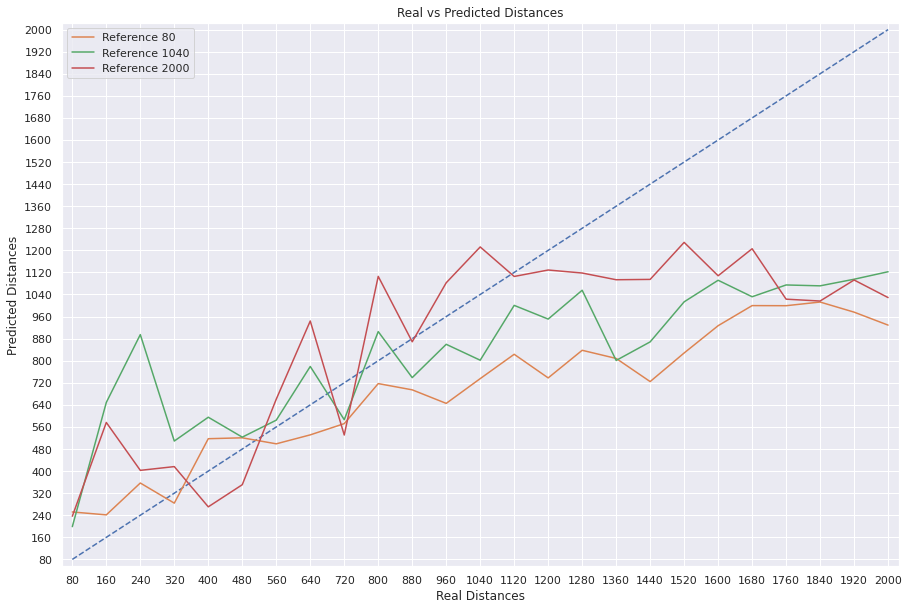

-----------------------------------------------------------------------


In [104]:
# ------------------------------------------------------------
reference_eval_params=(30, [80, 1040, 2000], [80, 160, 240, 320, 400, 480, 560, 640, 720, 800, 880, 960, 1040, 1120, 1200, 1280, 1360, 1440, 1520, 1600, 1680, 1760, 1840, 1920, 2000])

res = {}
for r in reference_eval_params[1]: #[80, 1040, 2000]
  # Get reference data
  reference_data_df = saved_references[saved_references['Distance_km']==r]
  t_df = get_features_v2(saved_sample_freq_data_df, reference_data_df, rows_testing)
  t_df = t_df.sort_values(by='distance')

  Y = t_df.iloc[:, 0].to_numpy().reshape(-1,1)
  X = t_df.iloc[:, 1:t_df.shape[1]]
  y_test = sc_output_c.fit_transform(Y) # convert distances to values from 0 to 1
  x_test = sc_output_c.fit_transform(X) # convert features to values from 0 to 1

  y_test_pred=mm.predict(x_test)
  pred=list(y_test_pred)

  dist_min=80 # 80
  dist_max=2000 # 2000

  real=list(list(zip(*y_test))[0])
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

  dict_distance = {}
  label = t_df.iloc[:, 0].to_numpy()
  for d in reference_eval_params[2]:
    idx_val = np.where(label==d)
    dict_distance[d] = idx_val[0].tolist()

  pred_mean_res = []
  for dist, indices in dict_distance.items():
    sublist = [element for i, element in enumerate(pred_abs) if i in indices]
    pred_mean_res.append(np.mean(sublist))

  res[r] = pred_mean_res

print('-----------------------------------------------------------------------')
print('Resuslts')

plt.figure(figsize=(15, 10))
plt.plot(distances, distances,  linestyle='--')
plt.plot(distances, res[80], label='Reference 80')
plt.plot(distances, res[1040], label='Reference 1040')
plt.plot(distances, res[2000], label='Reference 2000')
plt.title('Real vs Predicted Distances')
plt.xlabel('Real Distances')
plt.ylabel('Predicted Distances')
plt.xlim(np.min(distances)-25, np.max(distances)+25)
plt.ylim(np.min(distances)-25, np.max(distances)+25)
plt.yticks(distances)
plt.xticks(distances)
plt.legend(loc="best")
plt.show()
print('-----------------------------------------------------------------------')
# ------------------------------------------------------------

## Test only pearson

In [ ]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 3, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
  return model

In [ ]:
def train_model(X_train, Y_train):
  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  def ann():
      model = Sequential()
      model.add(Dense(76, input_dim = 3, activation = 'tanh'))
      model.add(Dense(38,activation='tanh'))
      model.add(Dense(19,activation='tanh'))
      model.add(Dense(1))
      model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
      return model

  model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

  start_time = time.time()
  callback = [EarlyStopping(monitor='loss', patience=500)]#, TqdmCallback(verbose=2)]
  model_ann.fit(X_train, Y_train, callbacks=callback)
  time_train_ann = time.time() - start_time

  # Save model
  #pickle.dump(model_ann,open(path+"/Spectrum/NN/NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))

  if os.path.isfile(path+"/Spectrum/NN/NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5") is False:
    model_ann.model.save(path+"/Spectrum/NN/NNs/pearson_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")
  
  return model_ann

In [ ]:
def predict_test(model_ann, Y_test, X_test, sc_output, remove_outliers=0.05):
  print('Results (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')')
  # Predit
  start_time = time.time()
  Y_test_pred=model_ann.predict(X_test)
  pred=list(Y_test_pred)

  time_eval_ann=time.time()-start_time

  dist_min=sc_output.data_min_[0] # 80
  dist_max=sc_output.data_max_[0] # 2000

  real=list(list(zip(*Y_test))[0])
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar
  real_abs_e1 = real_abs
  real_abs_e2 = real_abs

  pred_abs_e1 = pred_abs
  pred_abs_e2 = pred_abs

  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  remove_outliers = math.ceil((len(error_v2)*remove_outliers)/2)

  for outlier in range(1, remove_outliers+1):
    min_idx_e1 = np.argmin(error)
    max_idx_e1 = np.argmax(error)

    min_idx_e2 = np.argmin(error_v2)
    max_idx_e2 = np.argmax(error_v2)

    error = np.delete(error, min_idx_e1)
    error = np.delete(error, max_idx_e1)
    real_abs_e1 = np.delete(real_abs_e1, min_idx_e1)
    real_abs_e1 = np.delete(real_abs_e1, max_idx_e1)
    pred_abs_e1 = np.delete(pred_abs_e1, min_idx_e1)
    pred_abs_e1 = np.delete(pred_abs_e1, max_idx_e1)

    error_v2 = np.delete(error_v2, min_idx_e2)
    error_v2 = np.delete(error_v2, max_idx_e2)
    real_abs_e2 = np.delete(real_abs_e2, min_idx_e1)
    real_abs_e2 = np.delete(real_abs_e2, max_idx_e1)
    pred_abs_e2 = np.delete(pred_abs_e2, min_idx_e1)
    pred_abs_e2 = np.delete(pred_abs_e2, max_idx_e1)

  res=pd.DataFrame({"dist":real_abs_e1,"pred":pred_abs_e1,"error":error})
  res.to_csv(path+"/Spectrum/NN/NN_results_error/new_data_pearson_results_curve_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)

  res_v2=pd.DataFrame({"dist":real_abs_e2,"pred":pred_abs_e2,"error":error_v2})
  res.to_csv(path+"/Spectrum/NN/NN_results_error/new_data_pearson_results_deltas_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)
  
  plt.plot(real_abs_e1,error,'bo')
  plt.xlabel('Distances') 
  plt.ylabel('Error') 
  plt.title("Results Curve (freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+")")
  plt.savefig(path+"/Spectrum/NN/NN_results_plots/new_data_pearson_results_curve_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".png")
  plt.show()
  
  plt.plot(real_abs_e2,error_v2,'bo')
  plt.xlabel('Distances') 
  plt.ylabel('Error') 
  plt.title("Results Deltas (freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+")")
  plt.savefig(path+"/Spectrum/NN/NN_results_plots/new_data_pearson_results_deltas_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".png")
  plt.show()


In [ ]:
num_of_freq_selected = 10
reference_amt = 30
training_input_path = path + "/Spectrum/NN/train_test_splits/new_data_training_data_NN_freq_10_reference_30.csv"
testing_input_path = path + "/Spectrum/NN/train_test_splits/new_data_testing_data_NN_freq_10_reference_30.csv"

training_df = pd.read_csv(training_input_path)
testing_df = pd.read_csv(testing_input_path)

Y = training_df.iloc[:, 0].to_numpy().reshape(-1,1)
X = training_df.iloc[:, 3:6]

sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_train_p = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_train_p = sc_input.fit_transform(X) # convert features to values from 0 to 1

Y = testing_df.iloc[:, 0].to_numpy().reshape(-1,1)
X = testing_df.iloc[:, 3:6]

sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_test_p = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_test_p = sc_input.fit_transform(X) # convert features to values from 0 to 1

In [ ]:
model_ann_p = train_model(X_train_p, Y_train_p)

Training model (freq_10_reference_30)...


Results (freq_10_reference_30)


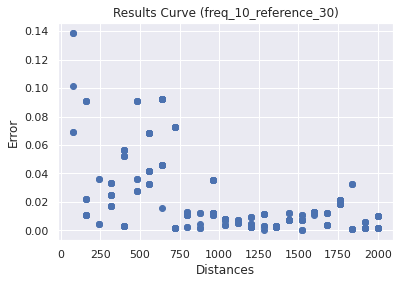

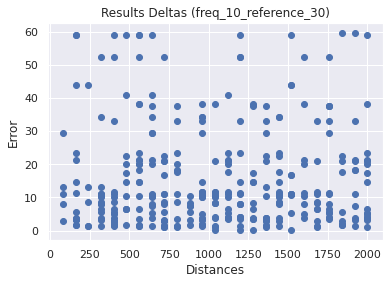

In [ ]:
predict_test(model_ann_p, Y_test_p, X_test_p, sc_output)

## Test only stats

In [ ]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 3, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
  return model

In [ ]:
# Load network
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

def ann():
  model = Sequential()
  model.add(Dense(76, input_dim = 4, activation = 'tanh'))
  model.add(Dense(38,activation='tanh'))
  model.add(Dense(19,activation='tanh'))
  model.add(Dense(1))
  model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
  return model

In [ ]:
def train_model(X_train, Y_train):
  print('Training model (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')...')
  from keras.models import Sequential
  from keras.layers import Dense,Conv2D, Flatten
  from keras.wrappers.scikit_learn import KerasRegressor
  from keras.callbacks import EarlyStopping
  from tqdm.keras import TqdmCallback

  def ann():
      model = Sequential()
      model.add(Dense(76, input_dim = 4, activation = 'tanh'))
      model.add(Dense(38,activation='tanh'))
      model.add(Dense(19,activation='tanh'))
      model.add(Dense(1))
      model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
      return model

  model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32, verbose=0)

  start_time = time.time()
  callback = [EarlyStopping(monitor='loss', patience=500)]#, TqdmCallback(verbose=2)]
  model_ann.fit(X_train, Y_train, callbacks=callback)
  time_train_ann = time.time() - start_time

  # Save model
  #pickle.dump(model_ann,open(path+"/Spectrum/NN/NNs/NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".pkl","wb"))

  if os.path.isfile(path+"/Spectrum/NN/NNs/stats_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5") is False:
    model_ann.model.save(path+"/Spectrum/NN/NNs/stats_new_data_NN_model_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".h5")
  
  return model_ann

In [ ]:
def predict_test(model_ann, Y_test, X_test, sc_output, remove_outliers=0.05):
  print('Results (freq_'+str(num_of_freq_selected)+'_reference_'+str(reference_amt)+')')
  # Predit
  start_time = time.time()
  Y_test_pred=model_ann.predict(X_test)
  pred=list(Y_test_pred)

  time_eval_ann=time.time()-start_time

  dist_min=sc_output.data_min_[0] # 80
  dist_max=sc_output.data_max_[0] # 2000

  real=list(list(zip(*Y_test))[0])
  real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real)) # convert back to distances values from scalar
  real_abs=[int(np.round(i)) for i in real_abs]
  pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred)) # convert back to distances values from scalar

  real_abs_e1 = real_abs
  real_abs_e2 = real_abs

  pred_abs_e1 = pred_abs
  pred_abs_e2 = pred_abs

  error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))
  error_v2 = np.abs(np.subtract(np.array(real_abs),np.array(pred_abs)))

  remove_outliers = math.ceil((len(error_v2)*remove_outliers)/2)

  for outlier in range(1, remove_outliers+1):
    min_idx_e1 = np.argmin(error)
    max_idx_e1 = np.argmax(error)

    min_idx_e2 = np.argmin(error_v2)
    max_idx_e2 = np.argmax(error_v2)

    error = np.delete(error, min_idx_e1)
    error = np.delete(error, max_idx_e1)
    real_abs_e1 = np.delete(real_abs_e1, min_idx_e1)
    real_abs_e1 = np.delete(real_abs_e1, max_idx_e1)
    pred_abs_e1 = np.delete(pred_abs_e1, min_idx_e1)
    pred_abs_e1 = np.delete(pred_abs_e1, max_idx_e1)

    error_v2 = np.delete(error_v2, min_idx_e2)
    error_v2 = np.delete(error_v2, max_idx_e2)
    real_abs_e2 = np.delete(real_abs_e2, min_idx_e1)
    real_abs_e2 = np.delete(real_abs_e2, max_idx_e1)
    pred_abs_e2 = np.delete(pred_abs_e2, min_idx_e1)
    pred_abs_e2 = np.delete(pred_abs_e2, max_idx_e1)

  res=pd.DataFrame({"dist":real_abs_e1,"pred":pred_abs_e1,"error":error})
  res.to_csv(path+"/Spectrum/NN/NN_results_error/new_data_stats_results_curve_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)

  res_v2=pd.DataFrame({"dist":real_abs_e2,"pred":pred_abs_e2,"error":error_v2})
  res.to_csv(path+"/Spectrum/NN/NN_results_error/new_data_stats_results_deltas_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".csv", header=True, index=False)
  
  plt.plot(real_abs_e1,error,'bo')
  plt.xlabel('Distances') 
  plt.ylabel('Error') 
  plt.title("Results Curve (freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+")")
  plt.savefig(path+"/Spectrum/NN/NN_results_plots/new_data_stats_results_curve_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".png")
  plt.show()
  
  plt.plot(real_abs_e2,error_v2,'bo')
  plt.xlabel('Distances') 
  plt.ylabel('Error') 
  plt.title("Results Deltas (freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+")")
  plt.savefig(path+"/Spectrum/NN/NN_results_plots/new_data_stats_results_deltas_freq_"+str(num_of_freq_selected)+"_reference_"+str(reference_amt)+".png")
  plt.show()

In [ ]:
num_of_freq_selected = 10
reference_amt = 30
training_input_path = path + "/Spectrum/NN/train_test_splits/new_data_training_data_NN_freq_10_reference_30.csv"
testing_input_path = path + "/Spectrum/NN/train_test_splits/new_data_testing_data_NN_freq_10_reference_30.csv"

training_df = pd.read_csv(training_input_path)
testing_df = pd.read_csv(testing_input_path)

Y = training_df.iloc[:, 0].to_numpy().reshape(-1,1)
X = training_df.iloc[:, [1, 2, 5, 6]]

sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_train_s = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_train_s = sc_input.fit_transform(X) # convert features to values from 0 to 1

Y = testing_df.iloc[:, 0].to_numpy().reshape(-1,1)
X = testing_df.iloc[:, [1, 2, 5, 6]]


sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
Y_test_s = sc_output.fit_transform(Y) # convert distances to values from 0 to 1
X_test_s = sc_input.fit_transform(X) # convert features to values from 0 to 1

In [ ]:
model_ann_s = train_model(X_train_s, Y_train_s)

Training model (freq_10_reference_30)...


Results (freq_10_reference_30)


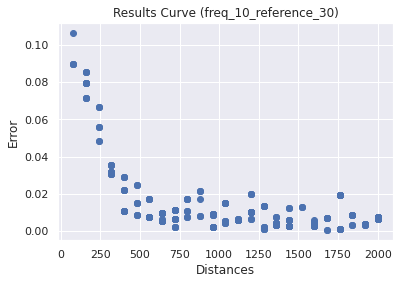

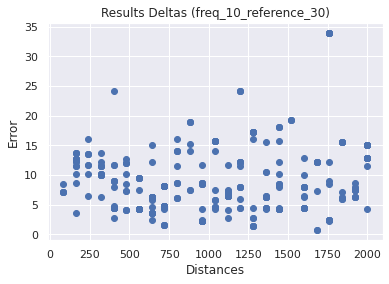

In [ ]:
predict_test(model_ann_s, Y_test_s, X_test_s, sc_output)